# Model selection - compare different material laws

Author: Audrey Olivier, 12/13/2018

In this notebook, we revisit a small finite element problem from Sfepy, see http://sfepy.org/doc/examples/large_deformation/compare_elastic_materials.html, where three material laws are compared: linear elastic, hyperelastic neo-Hookean, hyperelastic Mooney-Rivlin (the python package Sfepy should be downloaded prior to running this example).

We illustrate the use of Model Selection for choosing the materials law that best explain some data. Noisy data is generated synthetically.

First let's look at one run of each of these models.

In [1]:
import numpy as np
from compare_elastic_materials import *

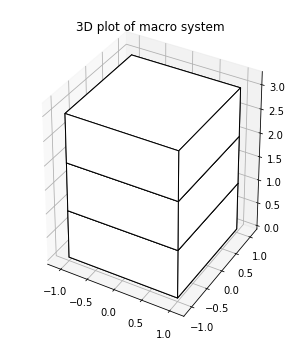

In [2]:
disp={}
load={}
colors={'linear':'red', 'neo_hookean':'green', 'mooney_rivlin':'blue'}
# Linear elastic
x0 = [5.769, 3.846]
disp['linear'], load['linear'] = one_simulation_linear(x0, plot_mesh_bool=True, return_load=True)
# neo-Hookean
x0 = [3.846]
disp['neo_hookean'], load['neo_hookean'] = one_simulation_neo_hookean(x0, plot_mesh_bool=False, return_load=True)
# Mooney-Rivlin
x0 = [1.923, 1.923]
disp['mooney_rivlin'], load['mooney_rivlin'] = one_simulation_mooney_rivlin(x0, plot_mesh_bool=False, return_load=True)

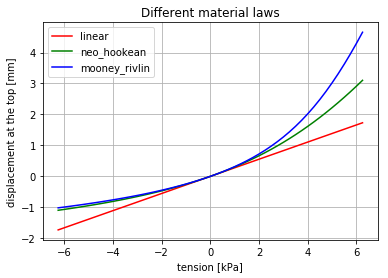

In [3]:
# plot displacements
fig, ax = plt.subplots()
for key, val in disp.items():
    ax.plot(load[key], val, label=key, color=colors[key])
ax.legend()
ax.grid(True)
ax.set_xlabel('tension [kPa]')
ax.set_ylabel('displacement at the top [mm]')
ax.set_title('Different material laws')
plt.show(fig)

### Generate synthetic noisy data from Mooney-Rivlin material

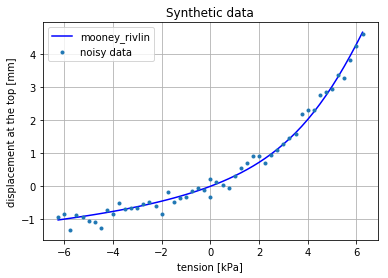

In [4]:
var_noise = 0.2**2
noisy_data = disp['mooney_rivlin']+np.random.normal(scale=np.sqrt(var_noise), size=disp['mooney_rivlin'].shape)
fig, ax = plt.subplots()
ax.plot(load['mooney_rivlin'],disp['mooney_rivlin'],color=colors['mooney_rivlin'],label='mooney_rivlin')
ax.plot(load['mooney_rivlin'], noisy_data, marker='.', linestyle='none', label='noisy data')
ax.legend()
ax.grid(True)
ax.set_xlabel('tension [kPa]')
ax.set_ylabel('displacement at the top [mm]')
ax.set_title('Synthetic data')
plt.show(fig)

### Learn which model best fits the data using information criteria

In [5]:
# Import necessary packages from UQpy
from UQpy.Inference import Model, InfoModelSelection

In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'neo_hookean', 'mooney_rivlin']
n_param_list = [2, 1, 2]
candidate_models = []
for i, model_name in enumerate(names):
    M = Model(model_type='python', n_params=n_param_list[i], model_name=model_name,
              model_script='compare_elastic_materials.py', model_object_name = 'one_simulation_'+model_name,
              error_covariance=var_noise)
    candidate_models.append(M)

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models = candidate_models, data = noisy_data, method = 'BIC', 
                              sorted_outputs = False, 
                              iter_optim = [3,3,3], bounds=[((1,7), (1,7)), ((1,7),), ((1,7), (1,7))])
for name, proba in zip(selector.model_names, selector.probabilities):
    print('probability of model {}: {}'.format(name, proba))

probability of model linear: 1.1892472659592857e-171
probability of model neo_hookean: 0.028468625994282955
probability of model mooney_rivlin: 0.9715313740057171


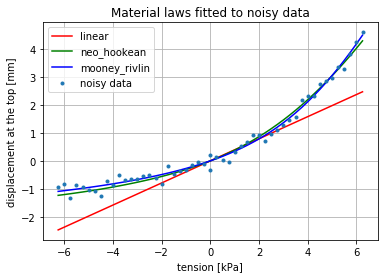

In [8]:
# Re-run the forward model with the fitted parameters
disp={}
load={}
colors={'linear':'red', 'neo_hookean':'green', 'mooney_rivlin':'blue'}
# Linear elastic
x0 = selector.fitted_params[0]
disp['linear'], load['linear'] = one_simulation_linear(x0, return_load=True)
# neo-Hookean
x0 = selector.fitted_params[1]
disp['neo_hookean'], load['neo_hookean'] = one_simulation_neo_hookean(x0, return_load=True)
# Mooney-Rivlin
x0 = selector.fitted_params[2]
disp['mooney_rivlin'], load['mooney_rivlin'] = one_simulation_mooney_rivlin(x0, return_load=True)

# plot displacements
fig, ax = plt.subplots()
for key, val in disp.items():
    ax.plot(load[key], val, label=key, color=colors[key])
ax.plot(load['mooney_rivlin'], noisy_data, marker='.', linestyle='none', label='noisy data')
ax.legend()
ax.grid(True)
ax.set_xlabel('tension [kPa]')
ax.set_ylabel('displacement at the top [mm]')
ax.set_title('Material laws fitted to noisy data')
plt.show(fig)